<a href="https://colab.research.google.com/github/Radperia/SIGNATE_student_2020/blob/master/SIGNATE_Tfidf_LogisticRegreession.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [3]:
class_names = ['DataScientist', 'MachineLearningEngineer', 'SoftwareEngineer', 'Consultant']

train = pd.read_csv('./drive/My Drive/SIGNATE/train.csv').fillna(' ')
test = pd.read_csv('./drive/My Drive/SIGNATE/test.csv').fillna(' ')

train_text = train['description']
test_text = test['description']
all_text = pd.concat([train_text, test_text])

In [23]:
train['DataScientist'] = 0
train['MachineLearningEngineer'] = 0
train['SoftwareEngineer'] = 0
train['Consultant'] = 0

print(train['jobflag'][2])

4


In [25]:
# カッコいい書き方が分からない

for i in range(train.shape[0]):
    if(train['jobflag'][i]==1):
        train['DataScientist'][i]=1
    elif(train['jobflag'][i]==2):
        train['MachineLearningEngineer'][i]=1
    elif(train['jobflag'][i]==3):
        train['SoftwareEngineer'][i]=1
    elif(train['jobflag'][i]==4):
        train['Consultant'][i]=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: Set

In [26]:
train.head()

,id,description,jobflag,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,0,"Executes and writes portions of testing plans,...",2,0,1,0,0
1,1,Maintain Network Performance by assisting with...,3,0,0,1,0
2,2,Supports the regional compliance manager with ...,4,0,0,0,1
3,3,Keep up to date with local and national busine...,1,1,0,0,0
4,4,Assist with Service Organization Control (SOC)...,4,0,0,0,1


In [4]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [5]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [6]:
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [67]:
scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})

for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C = 0.1, solver = 'sag', class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring = 'f1_macro'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}',format(np.mean(scores)))

CV score for class DataScientist is 0.7743804552297915
CV score for class MachineLearningEngineer is 0.6765586111874455
CV score for class SoftwareEngineer is 0.7554248796077404
CV score for class Consultant is 0.6946674426920397
Total CV score is {} 0.7252578471792543


In [68]:
submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant
0,2931,0.403644,0.417116,0.455539,0.553538
1,2932,0.323030,0.401911,0.571169,0.473124
2,2933,0.386227,0.434306,0.539379,0.449900
3,2934,0.748689,0.441437,0.261718,0.430377
4,2935,0.350733,0.280741,0.522598,0.607325
...,...,...,...,...,...
1738,4669,0.740106,0.328287,0.281831,0.468838
1739,4670,0.349762,0.363716,0.537742,0.521873
1740,4671,0.503422,0.434173,0.445981,0.462055
1741,4672,0.409640,0.337619,0.483944,0.549001


In [69]:
submission['flag'] = 0

for i in range(submission.shape[0]):
    submission['flag'][i] = np.stack([submission['DataScientist'][i], submission['MachineLearningEngineer'][i], submission['SoftwareEngineer'][i], submission['Consultant'][i]]).argmax() + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [63]:
submission

,id,DataScientist,MachineLearningEngineer,SoftwareEngineer,Consultant,flag
0,2931,0.181715,0.115755,0.428288,0.249343,3
1,2932,0.148002,0.108233,0.544448,0.206363,3
2,2933,0.175246,0.117025,0.512206,0.193328,3
3,2934,0.440746,0.118859,0.242351,0.187284,1
4,2935,0.157103,0.084671,0.495168,0.283533,3
...,...,...,...,...,...,...
1738,4669,0.436159,0.095462,0.261436,0.206193,1
1739,4670,0.161105,0.101508,0.510126,0.232286,3
1740,4671,0.233000,0.117205,0.419055,0.200442,3
1741,4672,0.191930,0.095421,0.457131,0.249083,3


Text(0, 0.5, 'samples')

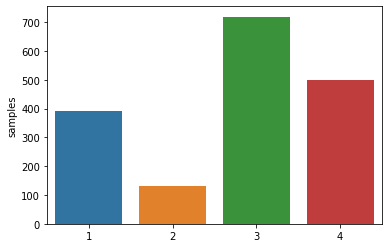

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

jobflag_vals = submission.flag.value_counts()
sns.barplot(jobflag_vals.index, jobflag_vals)
plt.gca().set_ylabel('samples')

In [72]:
submission.to_csv('balanced_LR.csv', index=False)

from google.colab import files
files.download('balanced_LR.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>